# Time Series Clustering with K-Means and Euclidean distance for features engineered from individual columns (x, y, z)


----
**Specification of experiment:**
- scripted trips only
- Use x, y, z columns
- Calculate Euclidean distance matrix
- Cluster with k-means/HDBScan and evaluate against ground truth of transport mode clusters.

-----
**Results:**


* Estimated number of clusters: 3
* True number of clusters: 3
* Homogeneity: 0.664
* Completeness: 0.493
* V-measure: 0.566
* Adjusted MI: 0.492
* Silhouette Coefficient: 0.698


*Assume that transport modes are true clusters

In [94]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns
import tsfresh
import hdbscan

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import get_distribution_of_cluster_labels_for
from visualization.visualize import plot_distribution_of_cluster_labels_for_target
from visualization.visualize import plot_all_trips_with_cluster_coloring
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets
from visualization.visualize import plot_3D




%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels
%aimport features.build_features
from features.build_features import calculate_maximum_break_length
from features.build_features import calculate_maximum_acceleration_length
#from features.build_features import engineer_features_with_tsfresh
%aimport models.cluster
from models.cluster import get_clustering_performance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
# Set to true if all trips should be plotted at the end
plot_all_trips = False

data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

Start with scripted trips.

In [96]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["x", "y", "z"])
# Keep only scripted trips for each dimension + total.
scripted_trips_only = [
    trips_cut_per_30_sec_for_dim[trips_cut_per_30_sec_for_dim["scripted"] == 1].reset_index(drop=True)
    for trips_cut_per_30_sec_for_dim in trips_cut_per_30_sec 
]

Prepare trip dataframe for tsfresh.

In [102]:
# Drop categorical columns.
dfs = scripted_trips_only
dfs = [df.drop(categorical_columns,axis=1) for df in dfs]

# Stack dataframe so that it can be parsed by tsfresh. Copy indices into columns with .reset_index().
dfs = [pd.DataFrame(df.stack(), columns=['value']).reset_index() for df in dfs]

# Rename columns for first dataframe (we'll use that one afer merging).
dfs[0].columns = ['snippet_id', 'snippet_time', 'x']

# Join data from different dimensions to one single one.
dfs[0]['y'] = dfs[1]['value']
dfs[0]['z'] = dfs[2]['value']

# Use merged dataframe from here on.
df = dfs[0]

# Cast values to numeric attributes.
df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])
df['z'] = pd.to_numeric(df['z'])

### Choose which features to use

Use `tsfresh` to find relevant features (with default settings).

In [103]:
extraction_settings = tsfresh.feature_extraction.ComprehensiveFCParameters()
settings_minimal = tsfresh.feature_extraction.settings.MinimalFCParameters()

extracted_features = tsfresh.extract_features(
    df, 
    column_id="snippet_id", 
    column_sort="snippet_time",
    default_fc_parameters=extraction_settings,
    impute_function=tsfresh.utilities.dataframe_functions.impute,
    n_jobs=3
)

Feature Extraction: 100%|██████████| 15/15 [21:51<00:00, 87.41s/it]  


In [111]:
# Run evaluation of features against baseline ground truth of three transport modes.
# Note: n in ground truth has to correlate with number of IDs (in this case: Snippet ID), not with total number of samples (in this case: number of seconds).
features_filtered = tsfresh.select_features(
    extracted_features, 
    scripted_trips_only[0]['mode'],
    ml_task='classification',
    fdr_level=0.001
)

print(features_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 0 to 910
Columns: 968 entries, z__variance_larger_than_standard_deviation to y__ratio_beyond_r_sigma__r_0.5
dtypes: float64(968)
memory usage: 6.7 MB
None


In [151]:
features_used = pd.DataFrame(scale(features_filtered),columns=features_filtered.columns)
features_used.head(2)

variable,z__variance_larger_than_standard_deviation,x__variance_larger_than_standard_deviation,y__variance_larger_than_standard_deviation,z__number_crossing_m__m_1,z__number_crossing_m__m_0,z__number_crossing_m__m_-1,x__number_crossing_m__m_0,x__number_crossing_m__m_-1,x__number_crossing_m__m_1,z__range_count__max_1__min_-1,...,"x__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_5",x__symmetry_looking__r_0.2,"y__fft_coefficient__coeff_70__attr_""angle""",x__large_standard_deviation__r_0.2,z__ratio_beyond_r_sigma__r_0.5,x__approximate_entropy__m_2__r_0.1,y__ratio_beyond_r_sigma__r_3,y__ar_coefficient__k_10__coeff_2,y__ratio_beyond_r_sigma__r_2.5,y__ratio_beyond_r_sigma__r_0.5
0,1.474522,1.47078,1.489658,2.324427,1.684916,1.181475,2.186909,2.262287,2.256733,0.983065,...,0.905107,0.099889,-0.785251,-0.714688,0.003022,0.293028,-0.528121,-0.161069,-0.763783,0.400679
1,1.474522,1.47078,1.489658,2.289681,1.575953,1.243873,2.424341,2.541953,2.256733,1.062401,...,0.268281,0.099889,-0.788452,-0.714688,-0.302867,0.501616,-0.528121,0.639175,-0.673336,0.317346


### Calculate distance matrix for trip snippets using engineered feature set.

In [152]:
# Calculate euclidean norm on standardized features.
distance_matrix = pd.DataFrame(cdist(features_used, features_used, metric='sqeuclidean'))
# Append metadata to distance matrix (each row corresponds to one trip snippet and its distances to other trip snippets).
distance_matrix['mode'] = scripted_trips_only[0]['mode']
distance_matrix['token'] = scripted_trips_only[0]['token']

------
# Model Building

## Create Model with Clustering by KMeans

Use summaries of each distance

Explained Variance Ratio: [ 0.90887757  0.05911459  0.02015021  0.00327939]


Text(0.5,1,'Explained variance ratio of engineered features with PCA')

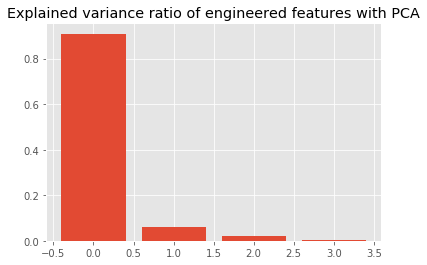

In [153]:
from sklearn.decomposition import PCA

n_components = 4
pca = PCA(n_components=4)
reduced = pd.DataFrame(pca.fit_transform(distance_matrix.drop(columns=["mode", "token"])))
#reduced = pd.DataFrame(pca.fit_transform(features_used))

features_used = reduced
print("Explained Variance Ratio:",pca.explained_variance_ratio_)

fig = plt.figure()
ax = plt.subplot(111)
ax.bar(np.arange(0, n_components), pca.explained_variance_ratio_)
ax.set_title("Explained variance ratio of engineered features with PCA")

In [154]:
from sklearn.cluster import KMeans
random_state = 0

clusterer = hdbscan.HDBSCAN(metric='sqeuclidean', min_cluster_size=30, min_samples=1)
clusterer.fit(features_used)

clusterer = KMeans(n_clusters=3, random_state=random_state).fit(distance_matrix.drop(columns=["mode", "token"]))
#clusterer = KMeans(n_clusters=3, random_state=random_state).fit(features_used)
cluster_labels = clusterer.labels_
distance_matrix["cluster_labels"]=cluster_labels

## Plot with PCA

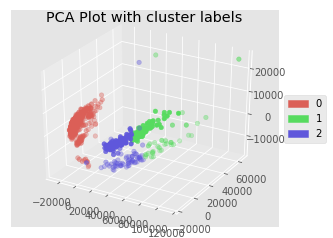

In [155]:
colors,color_patches = get_color_encoding(cluster_labels)
plot_3D(reduced.iloc[:,0],reduced.iloc[:,1],reduced.iloc[:,2], colors, color_patches,title="PCA Plot with cluster labels")


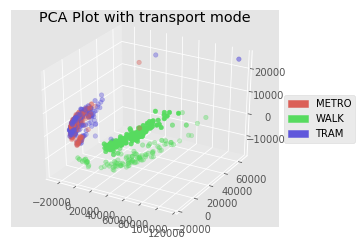

In [156]:
colors,color_patches = get_color_encoding(distance_matrix["mode"])
plot_3D(reduced.iloc[:,0],reduced.iloc[:,1],reduced.iloc[:,2], colors, color_patches,title="PCA Plot with transport mode")


-----
## Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [157]:
cluster_performance = get_clustering_performance(
    distance_matrix.drop(columns=["mode", "token"]),
    #features_used,
    cluster_labels,
    true_labels=distance_matrix["mode"]
)
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 3

 - True number of clusters: 3

 - Homogeneity: 0.664

 - Completeness: 0.493

 - V-measure: 0.566

 - Adjusted MI: 0.492

 - Silhouette Coefficient: 0.698

## Visualise Clustering on 2D - TSNE Plot:

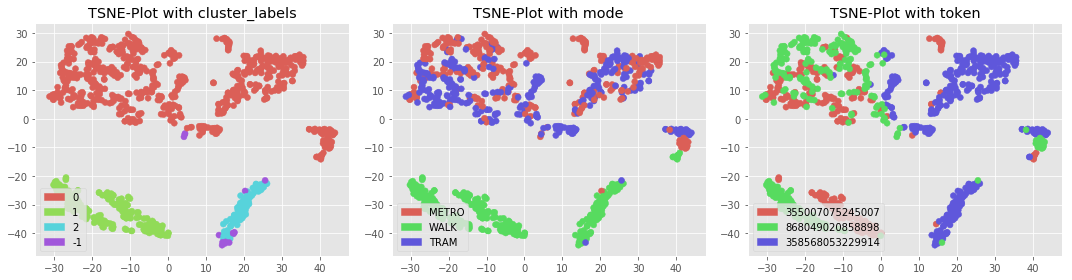

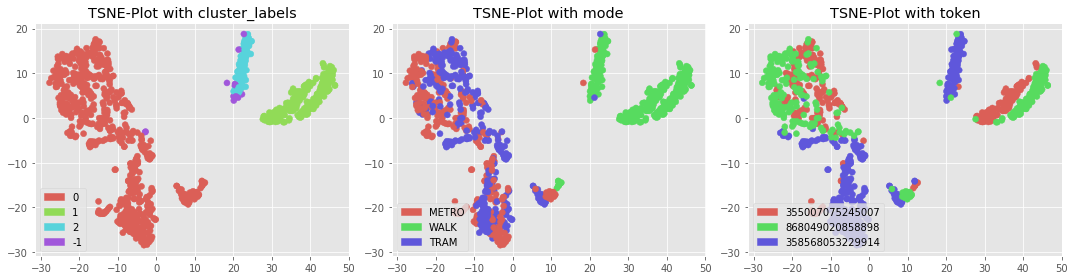

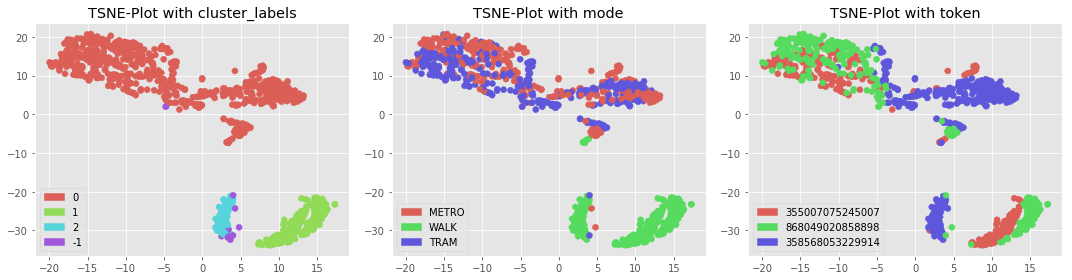

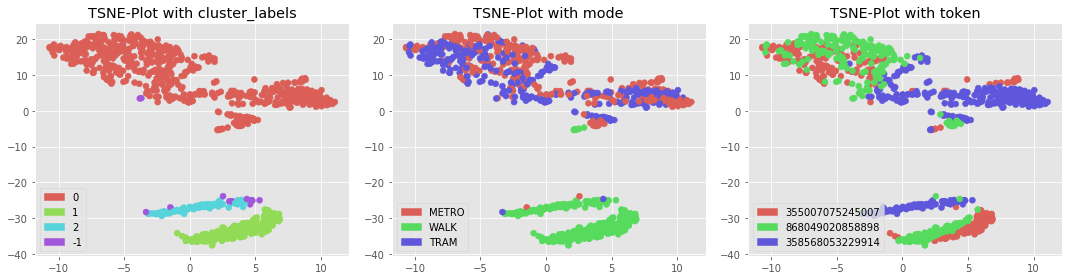

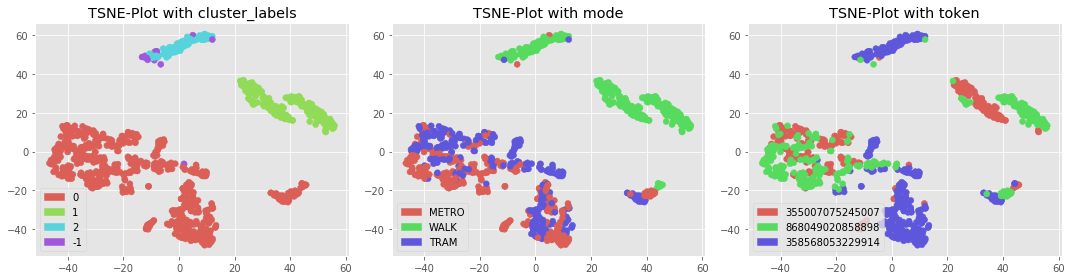

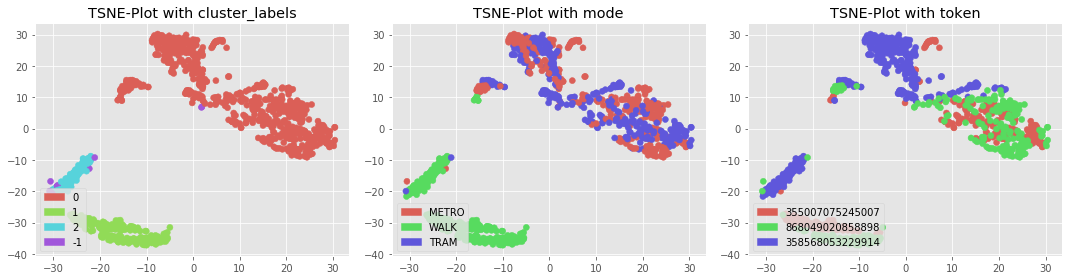

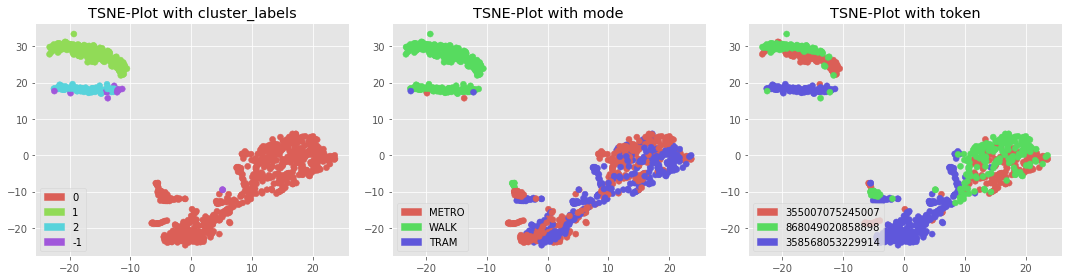

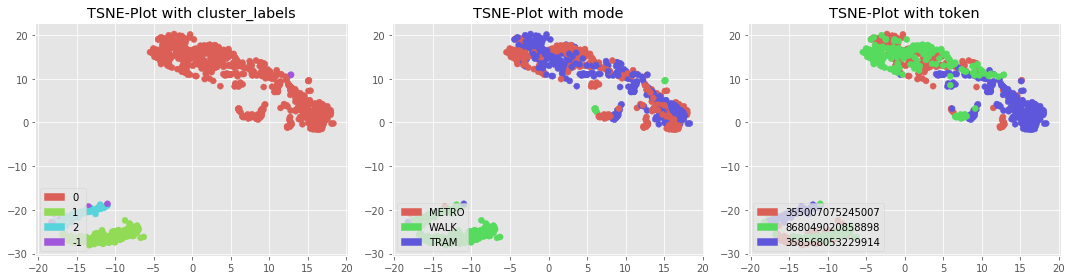

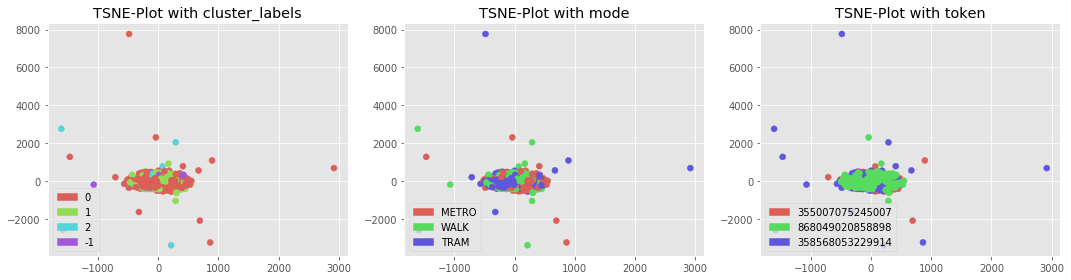

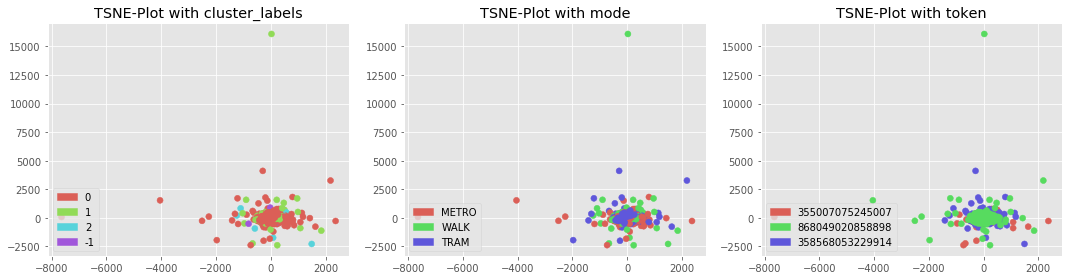

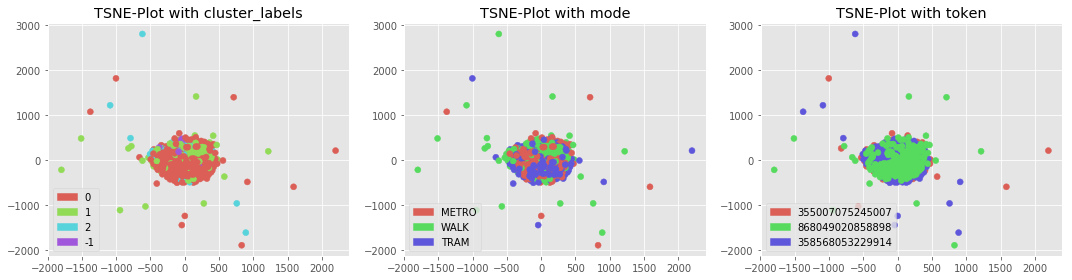

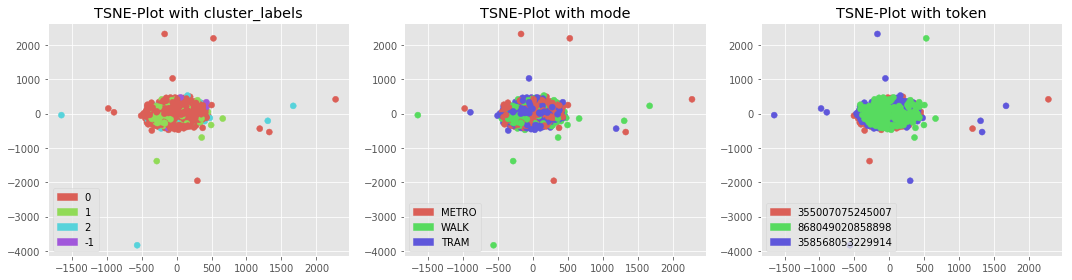

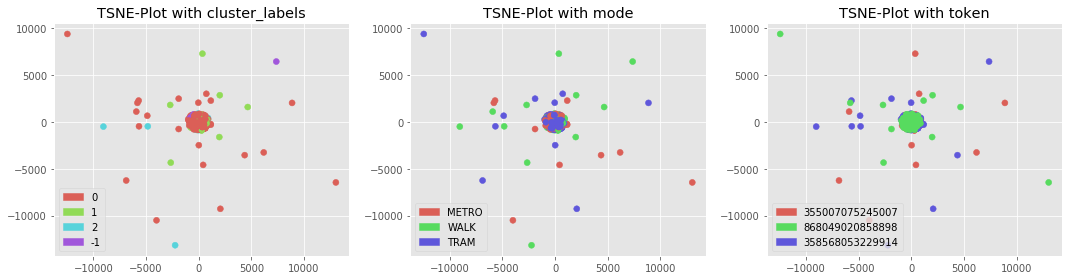

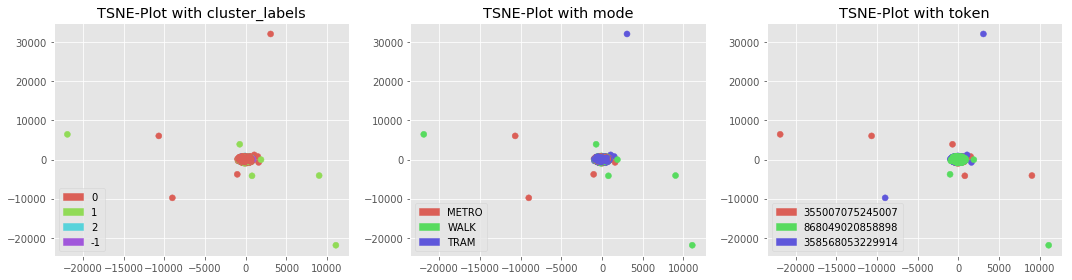

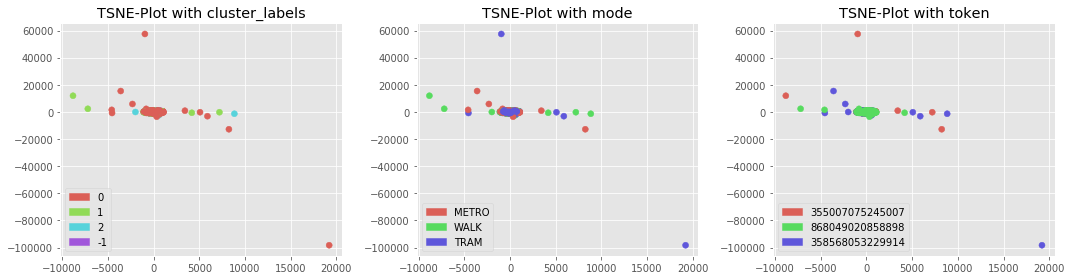

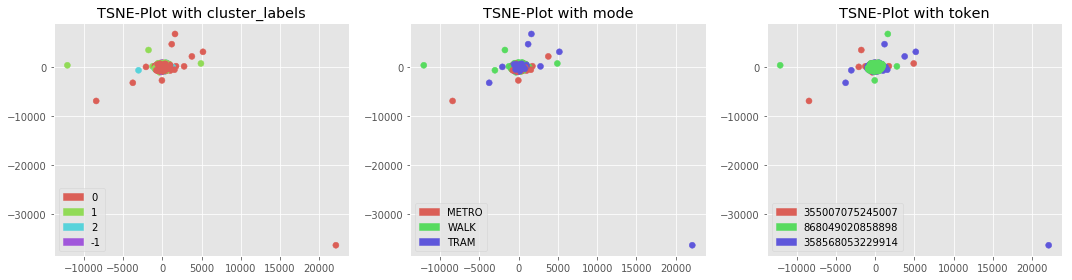

In [64]:
color_encodings = distance_matrix.loc[:,["cluster_labels","mode", "token"]]

for learning_rate in [50, 1000, 5000]:
    for perplexity in [25, 50, 75, 100]:
        plot_2D_tsne_with_coloring_per_targets(
            distance_matrix.drop(columns=["cluster_labels", "mode", "token"]), 
            color_encodings, 
            learning_rate=learning_rate,
            perplexity=perplexity
        )


## Inspect the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [414]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", distance_matrix)
mode_dist_df

,count_cluster_0,count_cluster_1,count_cluster_2,mode
0,229.0,40.0,13.0,WALK
1,0.0,0.0,328.0,TRAM
2,0.0,2.0,299.0,METRO


### Plot distribution of cluster labels for transport modes

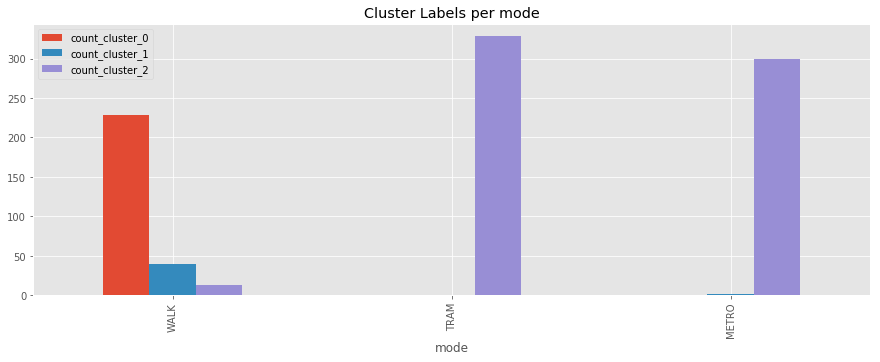

In [415]:
plot_distribution_of_cluster_labels_for_target("mode", distance_matrix)

### Plot distribution of cluster labels for tokens

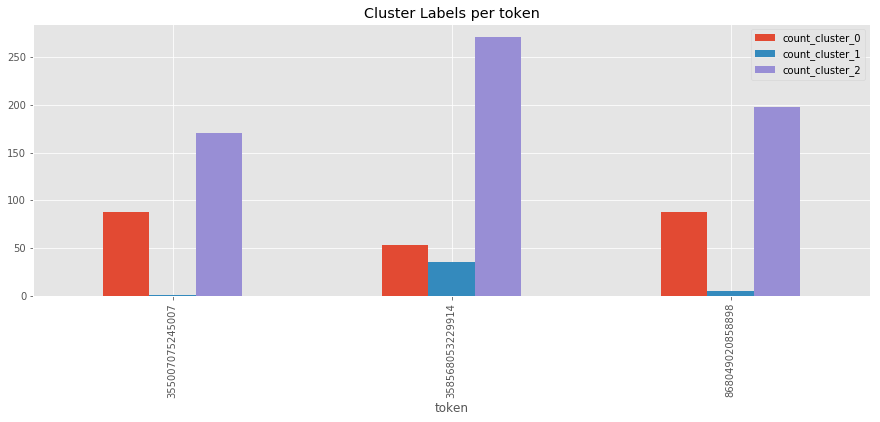

In [416]:
plot_distribution_of_cluster_labels_for_target("token", distance_matrix)

------
## Plot all trips with their clustering labels

In [417]:
if plot_all_trips:
    trips_unpacked = Preprocessor.unpack_all_trips(dfs)
    plot_all_trips_with_cluster_coloring(trips_unpacked, distance_matrix)